In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from models import MeanModel, SimpleModel, StandardModel, MixtureModel
from solver import Solver


/Users/kristjanjonsson/Development/Notebooks/venv/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Data

In [3]:
ls data/ml-100k/


README        u.info        u1.test       u4.base       ua.test
allbut.pl*    u.item        u2.base       u4.test       ub.base
mku.sh*       u.occupation  u2.test       u5.base       ub.test
u.data        u.user        u3.base       u5.test
u.genre       u1.base       u3.test       ua.base


In [4]:
def loadMovieLens(path):
    X_train = []
    y_train = []
    with open(join(path, 'u1.base')) as f:
        for line in f:
            uId, iId, r, timestamp = line.strip().split()
            X_train.append((int(uId), int(iId)))
            y_train.append(int(r))
    X_train = np.array(X_train, dtype=np.int32)
    y_train = np.array(y_train, dtype=np.float32)
            
    X_test = []
    y_test = []
    with open(join(path, 'u1.test')) as f:
        for line in f:
            uId, iId, r, timestamp = line.strip().split()
            X_test.append((int(uId), int(iId)))
            y_test.append(int(r))
    X_test = np.array(X_test, dtype=np.int32)
    y_test = np.array(y_test, dtype=np.float32)
    
    # Change Xs to 0 based indices.
    X_train -= 1
    X_test -= 1
              
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = loadMovieLens('data/ml-100k/')


In [287]:
nUsers = 1 + max(X_train[:, 0].max(), X_test[:, 0].max())
nItems = 1 + max(X_train[:, 1].max(), X_test[:, 1].max())
nUsers, nItems


(943, 1682)

In [7]:
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_test,
    'y_val': y_test
}


# Models

In [10]:
def plotTrainTest(solver):
    plt.plot(solver.train_loss_history, label='train')
    plt.plot(solver.val_loss_history, label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('MSE')

In [13]:
def rmse(y, y_pred):
    assert y.shape == y_pred.shape
    N = len(y)
    return np.sqrt(np.sum((y - y_pred)**2) / N)
    

## Mean model
Always predicts the mean of the training data

In [110]:
model = MeanModel()
model.fit(y_train)
y_pred = model.predict(y_test) 
rmse(y_test, y_pred)


1.1536759777852488

## Bias model
Model that has that predicts $r_{ui}$ based on biases for both users $u$ and items $i$:
$$r_{ui} = \alpha + \beta_u + \beta_i$$

In [112]:
model2 = SimpleModel(nUsers, nItems)
model2.params['alpha'] = y_train.mean()

solver2 = Solver(model2, data,
                 update_rule='adam',
                 optim_config={
                     'learning_rate': 1e-2,
                 },
                 lr_decay=0.95,
                 num_epochs=15, batch_size=1000,
                 print_every=100)
solver2.train()

(Iteration 1 / 1200) loss: 1.278819
(Epoch 0 / 15) train loss: 1.216378; val_loss: 1.325231
(Epoch 1 / 15) train loss: 0.970841; val_loss: 1.035861
(Iteration 101 / 1200) loss: 0.910933
(Epoch 2 / 15) train loss: 0.898137; val_loss: 0.962987
(Iteration 201 / 1200) loss: 0.842628
(Epoch 3 / 15) train loss: 0.866533; val_loss: 0.938713
(Iteration 301 / 1200) loss: 0.856035
(Epoch 4 / 15) train loss: 0.858109; val_loss: 0.927072
(Epoch 5 / 15) train loss: 0.837150; val_loss: 0.921091
(Iteration 401 / 1200) loss: 0.890927
(Epoch 6 / 15) train loss: 0.819667; val_loss: 0.919586
(Iteration 501 / 1200) loss: 0.793198
(Epoch 7 / 15) train loss: 0.840693; val_loss: 0.917549
(Iteration 601 / 1200) loss: 0.926138
(Epoch 8 / 15) train loss: 0.828889; val_loss: 0.915986
(Iteration 701 / 1200) loss: 0.932862
(Epoch 9 / 15) train loss: 0.850500; val_loss: 0.916709
(Epoch 10 / 15) train loss: 0.838834; val_loss: 0.918269
(Iteration 801 / 1200) loss: 0.858589
(Epoch 11 / 15) train loss: 0.814538; val_l

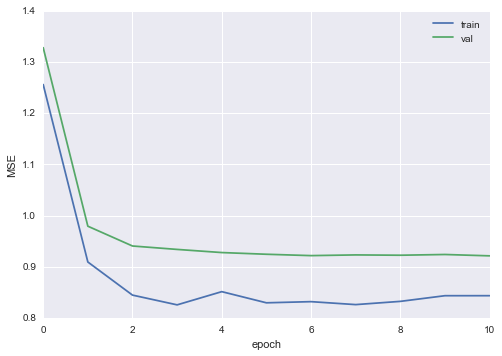

In [113]:
plotTrainTest(solver)

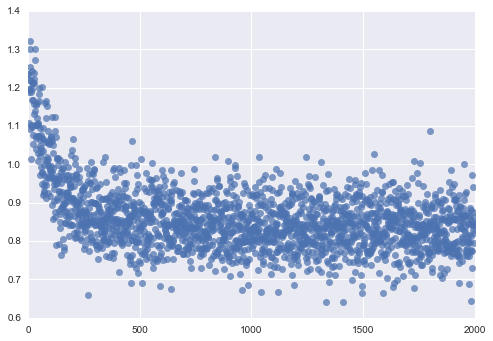

In [114]:
plt.plot(solver.loss_history, 'o', alpha=0.7)

In [117]:
y_pred = model2.predict(X_test)
rmse(y_test, y_pred)


0.95469164278970198

## Latent features models
Extension to the previous model that adds latent features $u_u$ and $v_i$ for each user $u$ and item $i$ to predict:
$$r_{ui} = \alpha + \beta_u + \beta_i + u_u^Tv_i$$

In [119]:
model3 = StandardModel(nUsers, nItems, latentDim=30, reg=1e-4)
model3.params['alpha'] = y_train.mean()
    
solver3 = Solver(model3, data,
                update_rule='adam',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=40, batch_size=1000,
                print_every=100)
solver3.train()


(Iteration 1 / 3200) loss: 1.304468
(Epoch 0 / 40) train loss: 1.247956; val_loss: 1.330336
(Epoch 1 / 40) train loss: 1.216234; val_loss: 1.275997
(Iteration 101 / 3200) loss: 1.183015
(Epoch 2 / 40) train loss: 1.082204; val_loss: 1.183780
(Iteration 201 / 3200) loss: 1.064266
(Epoch 3 / 40) train loss: 0.971992; val_loss: 1.085625
(Iteration 301 / 3200) loss: 1.056317
(Epoch 4 / 40) train loss: 0.934055; val_loss: 1.024626
(Epoch 5 / 40) train loss: 0.889403; val_loss: 0.989400
(Iteration 401 / 3200) loss: 0.899306
(Epoch 6 / 40) train loss: 0.820875; val_loss: 0.965357
(Iteration 501 / 3200) loss: 0.932844
(Epoch 7 / 40) train loss: 0.838405; val_loss: 0.948199
(Iteration 601 / 3200) loss: 0.836587
(Epoch 8 / 40) train loss: 0.806034; val_loss: 0.936438
(Iteration 701 / 3200) loss: 0.864116
(Epoch 9 / 40) train loss: 0.794968; val_loss: 0.926808
(Epoch 10 / 40) train loss: 0.772794; val_loss: 0.918680
(Iteration 801 / 3200) loss: 0.774870
(Epoch 11 / 40) train loss: 0.774379; val_l

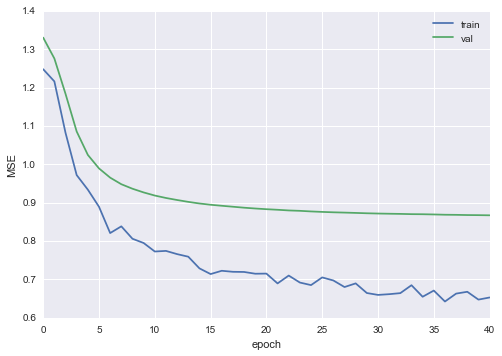

In [120]:
plotTrainTest(solver3)

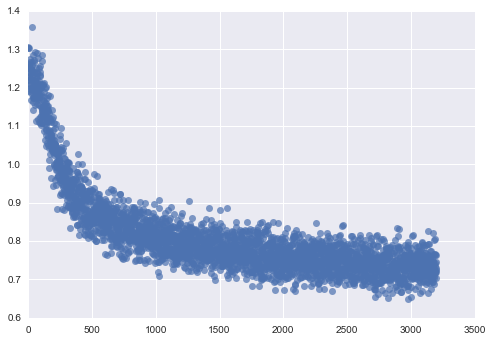

In [121]:
plt.plot(solver3.loss_history, 'o', alpha=0.7)

In [122]:
y_pred = model3.predict(X_test)
rmse(y_test, y_pred)


0.93101066555383782

# Mixture model

In [123]:
# We need 0 centered data for this model.
train_mean = y_train.mean()
y0_train = y_train - train_mean
y0_test = y_test - train_mean
data0 = {
    'X_train': X_train,
    'y_train': y0_train,
    'X_val': X_test,
    'y_val': y0_test
}


First try hardcoding the hidden states so it'll to be the same as the pmf model. Since pmf is in between the bias model and the latent model in complexity we expect its rmse to be in between as well, i.e. between 0.93 and 0.95

In [334]:
model4 = MixtureModel(nUsers, nItems, nProfiles=nUsers, latentDim=30, reg=1.5e-4)
model4.hiddenState['Z'] = np.eye(nUsers, dtype=np.float32)

solver4 = Solver(model4, data0,
                    update_rule='adam',
                    optim_config={
                        'learning_rate': 1e-3,
                    },
                    lr_decay=0.996,
                    num_epochs=50, batch_size=1000,
                    print_every=100)
solver4.train()


(Iteration 1 / 4000) loss: 1.237465
(Epoch 0 / 50) train loss: 1.239047; val_loss: 1.330967
(Epoch 1 / 50) train loss: 1.277446; val_loss: 1.321598
(Iteration 101 / 4000) loss: 1.260559
(Epoch 2 / 50) train loss: 1.147059; val_loss: 1.239917
(Iteration 201 / 4000) loss: 1.067505
(Epoch 3 / 50) train loss: 1.056696; val_loss: 1.151258
(Iteration 301 / 4000) loss: 1.047321
(Epoch 4 / 50) train loss: 0.994470; val_loss: 1.097921
(Epoch 5 / 50) train loss: 0.978135; val_loss: 1.060624
(Iteration 401 / 4000) loss: 1.036061
(Epoch 6 / 50) train loss: 0.914784; val_loss: 1.030715
(Iteration 501 / 4000) loss: 0.923997
(Epoch 7 / 50) train loss: 0.869371; val_loss: 1.007694
(Iteration 601 / 4000) loss: 0.902926
(Epoch 8 / 50) train loss: 0.854483; val_loss: 0.991305
(Iteration 701 / 4000) loss: 0.934678
(Epoch 9 / 50) train loss: 0.835847; val_loss: 0.976959
(Epoch 10 / 50) train loss: 0.814049; val_loss: 0.967268
(Iteration 801 / 4000) loss: 0.929125
(Epoch 11 / 50) train loss: 0.815727; val_l

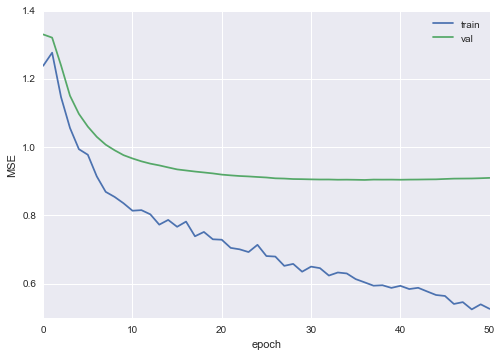

In [335]:
plotTrainTest(solver4)


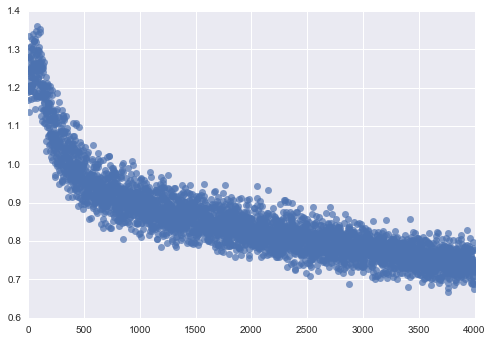

In [336]:
plt.plot(solver4.loss_history, 'o', alpha=0.7)


In [337]:
y_pred = model4.predict(X_test, mean=y_train.mean())
rmse(y_test, y_pred)


0.95036737345683853

In [338]:
y_pred = ppredict(model4, X_test, mean=y_train.mean())
rmse(y_test, y_pred)


0.95036737345683853

In [241]:
def ppredict(m, X, mean=0.0, clipRange=(1.0, 5.0)):
    '''Adds mean to the model prediction and clips the values to be in clipRange.'''
    Z = m.hiddenState['Z']
    U = m.params['U']
    V = m.params['V']
    pi = m.params['pi']

    users = X[:, 0]
    items = X[:, 1]
    # user2profile = np.argmax(Z, axis=1)
    # profiles = user2profile[users]

    # y = np.sum(V[items] * U[profiles], axis=1)
    scores = V[items].dot(U.T)
    scores *= Z[users]
    y = scores.sum(axis=1)

    y += mean
    low, high = clipRange
    y[y > high] = high
    y[y < low] = low
    return y

In [178]:
from IPython.display import clear_output


In [332]:

nProfiles = nUsers // 2
alpha = 5 * np.ones(nProfiles)
model5 = MixtureModel(nUsers, nItems, nProfiles=nProfiles, latentDim=50, alpha=alpha, reg=1e-4)
# Z = model5.hiddenState['Z']
# Z = np.random.rand(*Z.shape)
# Z /= Z.sum(axis=1).reshape((nUsers, 1))
# model5.hiddenState['Z'] = Z

solver5 = Solver(model5, data0,
                    update_rule='adam',
                    optim_config={
                        'learning_rate': 1e-3,
                    },
                    lr_decay=0.99,
                    num_epochs=20, batch_size=1000,
                    print_every=100)



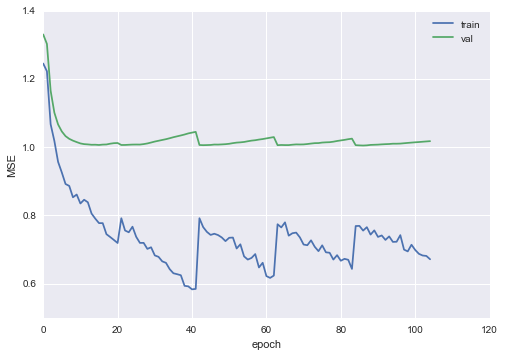

In [333]:

for _ in range(5):    
    solver5.train()
    clear_output()
    plotTrainTest(solver5)
    plt.show()
    model5.updatePi()
    model5.estimate(X_train, y_train)
    

In [290]:
y_pred = model5.predict(X_test, mean=y_train.mean())
rmse(y_test, y_pred)


0.99246915293688098

In [291]:
y_pred = ppredict(model5, X_test, mean=y_train.mean())
rmse(y_test, y_pred)


0.99246915293688098

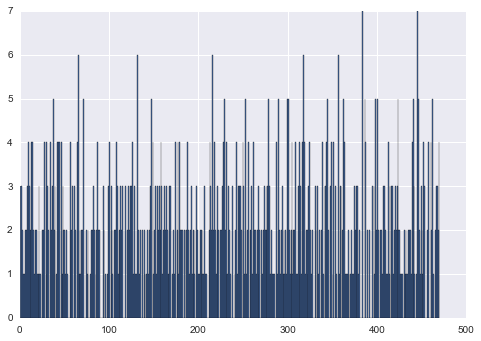

In [314]:
plt.hist(model5.hiddenState['Z'].argmax(axis=1), bins=nUsers//2);

In [257]:
x = np.arange(9).reshape(3, 3)

In [316]:
model5.hiddenState['Z'][0]

array([  2.77604565e-03,   8.35177239e-04,   2.59834104e-03,
         3.76466554e-03,   1.15815474e-03,   3.15753765e-03,
         2.96080030e-03,   2.42940000e-03,   4.13863505e-04,
         2.90283598e-03,   2.78334553e-03,   1.13379841e-03,
         3.31167106e-03,   3.91792762e-03,   4.02723514e-04,
         1.28414363e-04,   3.18578788e-03,   2.72797293e-03,
         4.01575352e-03,   1.83749585e-03,   4.22548202e-03,
         1.65018084e-03,   3.71494439e-03,   4.09940637e-03,
         2.83787293e-04,   1.46961663e-04,   3.41817152e-03,
         2.86323749e-03,   3.69894513e-05,   2.92155202e-05,
         3.48992163e-03,   1.01705296e-04,   1.18390669e-03,
         2.77385293e-03,   1.19591248e-03,   9.30767259e-05,
         3.17612104e-04,   3.62358113e-03,   4.16005751e-03,
         3.46437443e-03,   1.45384741e-03,   2.48908064e-03,
         1.82932843e-03,   1.62422940e-03,   4.52468426e-04,
         6.02409981e-04,   9.64613032e-04,   2.82520641e-03,
         2.30517646e-03,

In [259]:
x[np.arange(3), [0, 2, 2]] = 1

In [260]:
x

array([[1, 1, 2],
       [3, 4, 1],
       [6, 7, 1]])